- 16.1 - Estimating the mean and standard deviation of a normal distribution
 - [16.1.2 - Approximation by MCMC in JAGS (Python)](#Data)

## Chapter 16 - Metric-Predicted Variable on One or Two Groups

In [1]:
# %load ../../standard_import.txt
import pandas as pd
import numpy as np
import pymc3 as pmc
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import mode, norm

pd.set_option('display.notebook_repr_html', False)

#%config InlineBackend.figure_formats = {'pdf',}
%matplotlib inline
plt.style.use('seaborn-white')

In [2]:
# Below function takes an array as input.

def plot_posterior(dist, decimals=3, vert_ref=None, alpha=0.05, y_labels=False, ax=None):
       
    color = '#87ceeb'
    
    if ax == None:
        ax = plt.gca()
    
    ax_mode = mode(np.round(dist, decimals=decimals))[0][0] 
    hpd_interval = np.round(pmc.hpd(dist, alpha=alpha), decimals=decimals)

    # Histogram, Mode
    sns.distplot(dist, kde=False, color=color, ax=ax)
    plot_height = ax.get_ylim()[1]
    ax.text(ax_mode, plot_height*.9, 'mode = {}'.format(ax_mode),
            horizontalalignment='center', fontdict={'size':14})    

    # HPD interval
    ax.hlines(ax.get_ylim()[1]*0.01, *hpd_interval, linewidth=4)
    for interval_point in hpd_interval:
        ax.text(interval_point, plot_height*0.05, interval_point,
                horizontalalignment='center', fontdict={'size':14})
    ax.text(np.mean(hpd_interval), plot_height*0.13, '{}% HPD'.format((1-alpha)*100),
            horizontalalignment='center', fontdict={'size':14})

    # Reference line
    if vert_ref is None:
        ax.axvline(ax_mode, color='g', linestyle='dotted')
    else:
        ax.axvline(vert_ref, color='g', linestyle='dotted')

    # Set labels and axis
    if y_labels is False:
        ax.yaxis.set_visible(False)
        ax.spines['left'].set_visible(False)
    [ax.spines[spine].set_visible(False) for spine in ['right', 'top']]
    
    return(ax)

### Data

In [3]:
df = pd.read_csv('data/TwoGroupIQ.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 2 columns):
Score    120 non-null int64
Group    120 non-null object
dtypes: int64(1), object(1)
memory usage: 2.0+ KB


In [4]:
df.head()

   Score       Group
0    102  Smart Drug
1    107  Smart Drug
2     92  Smart Drug
3    101  Smart Drug
4    110  Smart Drug

In [5]:
# Mean and standard deviation
df.groupby('Group').agg(['mean', 'std'])

                 Score           
                  mean        std
Group                            
Placebo     100.035088  17.894497
Smart Drug  107.841270  25.445201

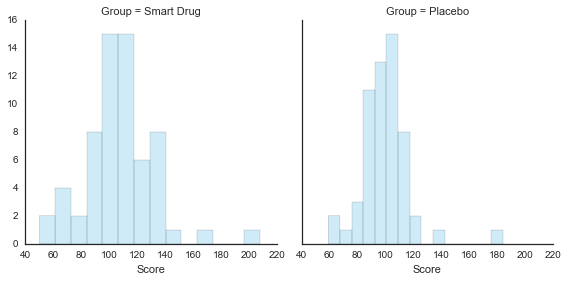

In [6]:
fg = sns.FacetGrid(df, col='Group', size=4)
fg.map(sns.distplot, 'Score', kde=False, color='#87ceeb');

In [7]:
# We are only interested in the scores of group 'Smart Drug'
y = df['Score'][df.Group == 'Smart Drug']

#### Model

In [8]:
with pmc.Model() as model:
    mu = pmc.Normal('mu', y.mean(), sd=y.std())
    sigma = pmc.Uniform('sigma', y.std()/1000, y.std()*1000)
    
    # PyMC's Normal likelihood can take either precision or standard deviation as an argument.
    likelihood = pmc.Normal('likelihood', mu, sd=sigma, observed=y)

Applied interval-transform to sigma and added transformed sigma_interval_ to model.


In [9]:
with model:
    trace = pmc.sample(10000)

Assigned NUTS to mu
Assigned NUTS to sigma_interval_
 [-----------------100%-----------------] 10000 of 10000 complete in 5.2 sec

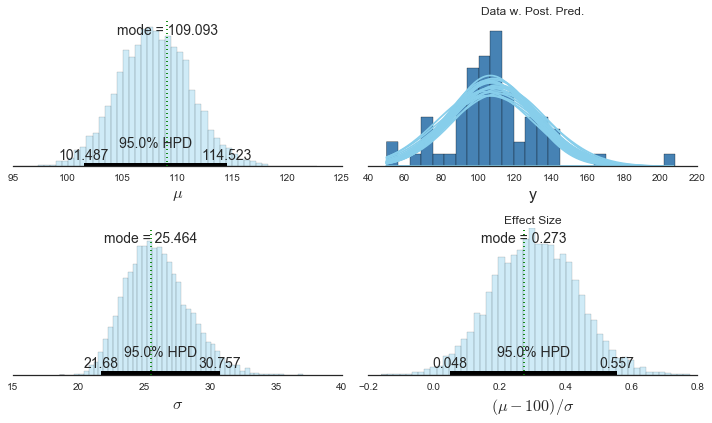

In [10]:
fig, [(ax1, ax2), (ax3, ax4)] = plt.subplots(2,2, figsize=(10,6))

burnin = 25

# Upper left
plot_posterior(trace['mu'][burnin:], ax=ax1)
ax1.set_xlabel('$\mu$', fontdict={'size':16})

# Upper right
tr_len = len(trace)
n_curves = 20
stepIdxVec = np.arange(0, tr_len, tr_len//n_curves)
# 20 ranges in order to  
x_range = np.arange(y.min(), y.max())
x = np.tile(x_range.reshape(-1,1), (1,20))

ax2.hist(y, bins=25, normed=True, color='steelblue')
ax2.plot(x, norm.pdf(x, trace['mu'][stepIdxVec], trace['sigma'][stepIdxVec]), c='#87ceeb')
ax2.set_xlabel('y', fontdict={'size':16})
ax2.set_title('Data w. Post. Pred.')
[ax2.spines[spine].set_visible(False) for spine in ['left', 'right', 'top']]
ax2.yaxis.set_visible(False)

# Lower left
plot_posterior(trace['sigma'][burnin:], ax=ax3)
ax3.set_xlabel('$\sigma$', fontdict={'size':16})

#Lower right
plot_posterior((trace['mu'][burnin:]-100)/trace['sigma'][burnin:], ax=ax4)
ax4.set_title('Effect Size')
ax4.set_xlabel('$(\mu - 100)/\sigma$', fontdict={'size':16})

plt.tight_layout();